In [46]:
import os
from datetime import datetime

from classes.Binary_Predictor import Binary_Predictor
from classes.Mean_LERP_Portfolio import Mean_LERP_Portfolio
from classes.Dataset import Dataset
from classes.Price import Price

from datetime import datetime
from ta import add_all_ta_features
import pandas as pd
import requests
import math
import numpy as np
import time
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
import matplotlib.pyplot as plt
from statistics import mean

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn import svm
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

OUTPUT_PATH = 'output\\20220212\\'

In [47]:
TECHNICAL_COLS = ['volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_vpt',
       'volume_nvi', 'volume_vwap', 'volatility_atr', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_ui', 'trend_macd', 'trend_macd_signal', 'trend_macd_diff',
       'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'trend_stc', 'momentum_rsi',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_stoch',
       'momentum_stoch_signal', 'momentum_wr', 'momentum_ao', 'momentum_kama',
       'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'others_dr', 'others_dlr', 'others_cr']

In [48]:
def GetCryptoPriceDF(symbol): 
    cols = ['open', 'high', 'low', 'close', 'volume']
    url = 'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol='+symbol+'&market=CNY&apikey='+AV_KEY
    print(url)
    r = requests.get(url)
    data = r.json()
    dic = data['Time Series (Digital Currency Daily)']
    df = pd.DataFrame.from_dict(dic, orient='index')
    df = df[['1a. open (CNY)', '2a. high (CNY)', '3a. low (CNY)', '4a. close (CNY)', '5. volume']]
    df = df.rename(columns={'1a. open (CNY)': 'open', '2a. high (CNY)': 'high', '3a. low (CNY)': 'low', '4a. close (CNY)': 'close', '5. volume':'volume'})
    df.index.name = 'date'
    df = df.sort_index(ascending = True)
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    return df

def SampleDataframe(df, date, no_samples):
    ind = df.index.get_loc(date)
    if ind-no_samples > 0:
        df = df.iloc[ind+1-no_samples:ind+1,:]
        return df
    return None

def TrainForDate(sampled_df, test_size, model, param_grid, pca_comps, no_its):
    data = sampled_df.to_numpy()
    features, label = data[:,:-1], data[:,-1]
    scaler = StandardScaler()
    scl_data = scaler.fit_transform(features)
    x, y = scl_data, label

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

    #fit pca on train, transform test
    pca = PCA(n_components=pca_comps, random_state=42)
    x_train = pca.fit_transform(x_train)
    x_test = pca.transform(x_test)
    
    print('pca variance: ' + str(sum(pca.explained_variance_ratio_)))

    clf = GridSearchCV(model, param_grid, refit=True, scoring='neg_root_mean_squared_error')
    best_model = clf.fit(x_train, y_train) # model.fit(x_train,y_train)
    y_train_pred = best_model.predict(x_train)
    y_test_pred = best_model.predict(x_test)

    accuracy_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    print('Params: ' + str(best_model.best_params_))
    PlotPredVsAct(y_test_pred, y_test, 'acc: ' + str(accuracy_test) + ', f1: ' + str(f1_test))
    
    return scaler, pca, best_model, f1_test
    
def PlotPredVsAct(pred, acts, title):
    plt.figure(figsize=(7, 2))
    plt.plot(pred, label = "predictions")
    plt.plot(acts, label = "actual")
    plt.legend(loc="upper left")
    
    plt.title(title)
    plt.show()
    
def PredictForDate(df, prev_price, date, scaler, pca, model):
    sampled_df = SampleDataframe(df, date, 1)
    data = sampled_df.to_numpy()
    x, y = data[:,:-1], data[:,-1]
    x = scaler.transform(x)
    x = pca.transform(x)
    y_pred = model.predict(x)
    return y_pred

def GenerateModelResults_OLD(df, base_prices, model_param_sets, pca_comps, no_its, no_samples, test_size, regression_range):
    model_sets_results = {}
    for key in model_param_sets:
        model_param_set = model_param_sets[key]
        #res_dict = {'date':[], 'open':[], 'close':[], 'prediction':[], 'test_mse':[]}
        res_dict = {'date':[], 'params':[], 'test_F1': [], 'prediction':[]}
        for i in regression_range:
            date = df.index[i]
            prev_date = df.index[i-1]
            open = base_prices.iloc[i]['open']
            close = base_prices.iloc[i]['close']

            sampled_df = SampleDataframe(df, prev_date, no_samples)
            scaler, pca, model, test_F1 = TrainForDate(sampled_df, test_size, model_param_set[0], model_param_set[1], pca_comps, no_its)
            prev_price = base_prices.iloc[i-1,-1]
            pred = PredictForDate(df, prev_price, date, scaler, pca, model)

            res_dict['date'].append(date)
            #res_dict['open'].append(open)
            #res_dict['close'].append(close)
            prediction = -1
            if pred[0] == 1:
                prediction = 1
            res_dict['params'].append(model.best_params)
            res_dict['test_F1'].append(test_F1)
            res_dict['prediction'].append(prediction)
            

        model_sets_results[key] = pd.DataFrame(res_dict)
    return model_sets_results

def GenerateModelResults(df, base_prices, model_param_set, pca_comps, no_its, no_samples, test_size, regression_range):
    res_dict = {'date':[], 'params':[], 'test_F1': [], 'prediction':[]}
    for i in regression_range:
        date = df.index[i]
        prev_date = df.index[i-1]

        sampled_df = SampleDataframe(df, prev_date, no_samples)
        scaler, pca, model, test_F1 = TrainForDate(sampled_df, test_size, model_param_set[0], model_param_set[1], pca_comps, no_its)
        prev_price = base_prices.iloc[i-1,-1]
        pred = PredictForDate(df, prev_price, date, scaler, pca, model)

        res_dict['date'].append(date)
        prediction = -1
        if pred[0] == 1:
            prediction = 1
        res_dict['params'].append(model.best_params_)
        res_dict['test_F1'].append(test_F1)
        res_dict['prediction'].append(prediction)

    return pd.DataFrame(res_dict)

def GeneratePredictorResultsOLD(df, base_prices,predictors,model_sets_results, run_range, rolls=[5,10,20]):
    predictors_results = {}
    for pred_key in predictors:
        res_dict = {'date':[],'open':[], 'close':[], 'high':[], 'low':[], 'agg_prediction':[], 'bet_dir':[], 'exit_price':[], 'act_perc_pal':[]}
        x = 0
        for i in run_range:
            date = df.index[i]
            open = base_prices.iloc[i]['open']
            close = base_prices.iloc[i]['close']
            high = base_prices.iloc[i]['high']
            low = base_prices.iloc[i]['low']

            predictor = predictors[pred_key]
            res_dict['date'].append(date)
            res_dict['open'].append(open)
            res_dict['close'].append(close)
            res_dict['high'].append(high)
            res_dict['low'].append(low)
            agg_pred = predictor.get_agg_prediction(x,model_sets_results)
            res_dict['agg_prediction'].append(agg_pred)
            res_dict['bet_dir'].append(predictor.bet_dir(agg_pred))
            res_dict['exit_price'].append(predictor.exit_at(agg_pred, open, close, high, low))
            res_dict['act_perc_pal'].append(predictor.percent_pal(agg_pred, open, close, high, low))
            x+=1

        metrics = pd.DataFrame(res_dict)
        for roll in rolls:
            metrics[str(roll) + 'D_mean'] = metrics['act_perc_pal'].rolling(roll).mean()
            metrics[str(roll) + 'D_cumprod'] = (1 + metrics['act_perc_pal']).rolling(roll).apply(np.prod, raw=True) - 1
        predictors_results[pred_key] = metrics
    return predictors_results

def GeneratePredictorResults(df, base_prices, predictor, model_results, run_range, norm_price):
    res_dict = {'date':[],'bought_at':[], 'prediction':[], 'sold_at':[], 'perc_pal':[]}
    x = 0
    for i in run_range:
        date = df.index[i]
        open = base_prices.iloc[i]['open']
        close = base_prices.iloc[i]['close']
        high = base_prices.iloc[i]['high']
        low = base_prices.iloc[i]['low']
        if norm_price:
            open = base_prices.iloc[i]['norm_open']
            close = base_prices.iloc[i]['norm_close']
            high = base_prices.iloc[i]['norm_high']
            low = base_prices.iloc[i]['norm_low']

        prediction = predictor.get_prediction(x, model_results)
        res_dict['date'].append(date)
        res_dict['bought_at'].append(open)
        res_dict['prediction'].append(prediction)
        res_dict['sold_at'].append(predictor.exit_at(prediction, open, close, high, low))
        res_dict['perc_pal'].append(predictor.percent_pal(prediction, open, close, high, low))
        x+=1

    return pd.DataFrame(res_dict)

def PlotPredictorResults(PredictorName, PredictorResults):
    fig, axs = plt.subplots(2,2, figsize=(12,6))
    axs[0, 0].set_title('rolling means')
    axs[0, 1].set_title('cumulative prods')
    
    for roll in [5,10,20]:
        mean_data = PredictorResults[str(roll) + 'D_mean'].dropna()
        sns.lineplot(data = PredictorResults, x = 'date', y = str(roll) + 'D_mean' , ax=axs[1,0])
        sns.kdeplot(mean_data,bw=0.25,ax=axs[0,0])

        cump_data = PredictorResults[str(roll) + 'D_cumprod'].dropna()
        sns.lineplot(data = PredictorResults, x = 'date', y = str(roll) + 'D_cumprod' , ax=axs[1,1])
        sns.kdeplot(cump_data,bw=0.25,ax=axs[0,1])
        
        if roll == 20:
            print(PredictorName + ', average 20D mean: ' + str(mean_data.mean()) + ', average 20 cumprod: ' + str(cump_data.mean()))
    plt.show()

#allocator============================================================================
def GeneratePortfolioReturns(portfolio_result, rolls = [3, 5]):
    df = portfolio_result[['date','weight','weighted_pal']]
    df = df.groupby(['date']).sum().reset_index()
    for roll in rolls:
        df[str(roll) + 'D_mean'] = df['weighted_pal'].rolling(roll).mean()
        df[str(roll) + 'D_cumprod'] = (1 + df['weighted_pal']).rolling(roll).apply(np.prod, raw=True) - 1
    return df

def GenerateInstructions(date, portfolio_result):
    df = portfolio_result[(portfolio_result['date'] == date)]
    df = df[['date','symbol','exit_method','bought_at','amount']]
    df = df.groupby(['date','symbol','exit_method','bought_at']).sum().reset_index()
    return df

#classifier====================================================================
def GetClassifierDatasetRunRange(start_date, end_date, dataset, classifier_data):
    run_ranges = []
    try:
        start_ind, end_ind = dataset.index.get_loc(start_date), dataset.index.get_loc(end_date)
    except:
        print('dates not found in underlying dataset, aborting generating classifier data')
        return
    if start_ind > end_ind:
        print('start_date is not earlier than end date, aborting generating classifier data')
    elif len(classifier_data) == 0:
        print('no file, running for full range: ' + start_date + ' - ' + end_date)
        run_ranges.append(range(start_ind, end_ind))
    else:
        existing_data = classifier_data[0]
        existing_sdate, existing_edate = existing_data['date'][0], existing_data['date'].iloc[-1]
        existing_start_ind, existing_end_ind = dataset.index.get_loc(existing_sdate), dataset.index.get_loc(existing_edate)
        if end_ind <= existing_end_ind and start_ind >= existing_start_ind:
            print('date range exists fully in file, not running any range')
        elif end_ind < existing_start_ind:
            print('existing file starts after specified end date - running up to start of file: ' + start_date + ' -> ' + existing_sdate)
            run_ranges.append(range(start_ind, existing_start_ind))
        elif start_ind > existing_end_ind:
            print('existing file ends before specified start date - running from end of file: ' + existing_edate + ' -> ' + end_date)
            run_ranges.append(range(existing_end_ind, end_ind))
        else: 
            if start_ind < existing_start_ind:
                print('running up to start of file: ' + start_date + ' -> ' + existing_sdate)
                run_ranges.append(range(start_ind, existing_start_ind))
            if end_ind > existing_end_ind:
                print('running from end of file: ' + existing_edate + ' -> ' + end_date)
                run_ranges.append(range(existing_end_ind, end_ind))
    return run_ranges  


<h1>Model Definition</h1>

In [49]:
prices = {'500.PAR': Price('500.PAR'),
          'NDAQ': Price('NDAQ'),
          'DAX': Price('DAX'),
          'AAPL': Price('AAPL'),
          'MSFT': Price('MSFT'),
          'AMZN': Price('AMZN'),
          'FB': Price('FB'),
          'GOOGL': Price('GOOGL'),
          'GOOG': Price('GOOG'),
          'TSLA': Price('TSLA'),
          'NVDA': Price('NVDA')}

datasets = {'500.PAR':Dataset(label='500.PAR', 
                              symbols=['500.PAR','NDAQ','DAX','AAPL','MSFT','AMZN','FB','GOOGL','GOOG'], 
                              pivot_cols = ['open','high','low','close','volume'], 
                              pivots = {1:[1,2,3,4,5,6,7,8,9,10],10:[10,20,30]},
                              technical_cols = ['volume_adi']),
           'NDAQ':Dataset(label='NDAQ', 
                              symbols=['500.PAR','NDAQ','DAX','AAPL','MSFT','AMZN','FB','GOOGL','GOOG'], 
                              pivot_cols = ['open','high','low','close','volume'], 
                              pivots = {1:[1,2,3,4,5,6,7,8,9,10],10:[10,20,30]},
                              technical_cols = ['volume_adi'])}

classifiers = {'M1': (MLPClassifier(random_state=42), {'hidden_layer_sizes':[(56,28),(28,14),(64,32,16)], 'max_iter':[100,200], 'activation':['relu'], 'solver':['adam'], 'learning_rate_init':[0.001,0.01]})}#,
                #'M2': (SVC(gamma=2),{'C':[0.025,0.25,1]}),
                #'M3': (DecisionTreeClassifier(),{'max_depth':[5,10]}),
                #'M4': (RandomForestClassifier(),{'max_depth':[5,10], 'n_estimators':[5,10],'max_features':[1]})}

predictors = {'P1': Binary_Predictor(threshold=0.0025, exit_method='at_close'),
             'P2': Binary_Predictor(threshold=0.0025, exit_method='capture_gains', capture_thresh = 0.0075),
             'P3': Binary_Predictor(threshold=0.0025, exit_method='at_close', trade_longs = False, tags=['shortonly']),
             'P4': Binary_Predictor(threshold=0.0025, exit_method='capture_gains', capture_thresh = 0.0075, trade_longs = False, tags=['shortonly'])}

allocators = {'A1': Mean_LERP_Portfolio(mean_periods = 5, min_lerp = 0.25, max_lerp = 1),
             'A2': Mean_LERP_Portfolio(mean_periods = 5, min_lerp = 0.25, max_lerp = 1, include_tags = ['shortonly'])}

<h1>Run Parameters</h1>

In [60]:
start_date, end_date = '2021-06-01', '2021-09-30'

#prices ignore start date - NOT IMPLEMENTED
price_load_mode = 'file_or_generate' #'file', 'generate', 'file_or_generate'
price_save_rslt = False

#datasets ignore start date - NOT IMPLEMENTED
dataset_load_mode = 'file_or_generate' #'file', 'generate', 'file_or_generate'
dataset_save_rslt = False

#use start and end date
classifier_load_mode = 'file_or_generate' #'file', 'generate', 'file_or_generate'
classifier_save_rslt = True

#use start and end date
trader_load_mode = 'file' #'file', 'generate'
trader_save_rslt = False

allocator_load_mode = 'generate' #'file', 'generate'
allocator_save_rslt = True

<h1> Prices </h1>

In [51]:
price_data = {}
for p in prices:
    if price_load_mode == 'file':
        print('loading price: ' + p)
        price_data[p] = pd.read_csv(OUTPUT_PATH + 'prices\\' + p + '.csv', index_col = 'date')
    elif price_load_mode == 'generate':
        print('downloading price: ' + p)
        price_data[p] = prices2[p].CreatePriceData()      
    elif price_load_mode == 'file_or_generate':
        print('loading or downloading price: ' + p)
        price_df = pd.read_csv(OUTPUT_PATH + 'prices\\' + p + '.csv', index_col = 'date')
        ls_dtstr_in_file = price_df.index[-1]
        ls_dt_in_file = datetime.strptime(last_date, '%Y-%m-%d').date()
        edt = datetime.strptime(end_date, '%Y-%m-%d').date()
        if edt > ls_dt_in_file:
            print('required date is greater than last date in file: ' + ls_dtstr_in_file + ' < ' + end_date)
            price_data[p] = prices2[p].CreatePriceData()
        else:
            print('file is up to date: ' + ls_dtstr_in_file + ' >= ' + end_date)
            price_data[p] = pd.read_csv(OUTPUT_PATH + 'prices\\' + p + '.csv', index_col = 'date')
    
    if price_save_rslt and price_load_mode != 'file':
         price_data[p].to_csv(OUTPUT_PATH + 'prices\\' + p + '.csv', index=True)  

loading or downloading price: 500.PAR
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: NDAQ
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: DAX
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: AAPL
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: MSFT
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: AMZN
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: FB
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: GOOGL
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: GOOG
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: TSLA
file is up to date: 2022-02-11 >= 2021-09-30
loading or downloading price: NVDA
file is up to date: 2022-02-11 >= 2021-09-30


In [52]:
print(price_data['500.PAR'].shape)
print(price_data['500.PAR'].tail())

(3016, 13)
               open     high      low    close  volume  open_1D_diff_perc  \
date                                                                        
2022-02-07  74.3731  74.5863  73.8862  74.1579    7822          -0.002939   
2022-02-08  74.2349  74.5648  73.8901  74.5648   10114          -0.001858   
2022-02-09  74.9191  75.5556  74.9191  75.4897    7360           0.009217   
2022-02-10  75.7833  75.7833  74.8639  74.8639    5834           0.011535   
2022-02-11  74.4168  74.9084  74.1498  74.3300  850950          -0.018032   

            open_1D_diff_perc_20D_STD  target_STD  leverage   norm_open  \
date                                                                      
2022-02-07                   0.010279       0.015  1.459332  108.535053   
2022-02-08                   0.010278       0.015  1.459419  108.339820   
2022-02-09                   0.010356       0.015  1.448476  108.518517   
2022-02-10                   0.010601       0.015  1.414956  107.230000   

<h1>Datasets </h1>

In [53]:
read_dataset_data = True

dataset_results = {}
for ds in datasets:
    if read_dataset_data:
        dataset_results[ds] = pd.read_csv(OUTPUT_PATH + 'datasets\\' + ds + '.csv', index_col = 'date')
    else:
        print('creating dataset for: ' + ds)
        dataset_results[ds] = datasets[ds].CreateDataset(price_data)
        dataset_results[ds].to_csv(OUTPUT_PATH + 'datasets\\' + ds + '.csv', index=True)  
    
for ds in datasets: #make sure base price data is only as long as it's dataset
    price_data[ds] = price_data[ds][price_data[ds].index.isin(dataset_results[ds].index)] 

In [54]:
print(dataset_results['500.PAR'].shape)
print(dataset_results['NDAQ'].shape)

(1827, 604)
(1827, 604)


<h1>Classifiers</h1>
<p>classifiers generate signals for each of the datesets</p>

In [61]:
#classifier training parameters
pca_comps = 150
no_samples = 400
test_size = 0.33

loading or generating classifier data for: 500.PAR, M1
running up to start of file: 2021-06-01 -> 2021-08-02
pca variance: 0.9722697992351711
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


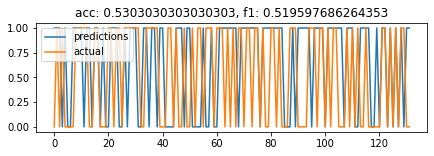

pca variance: 0.9728625273179324
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


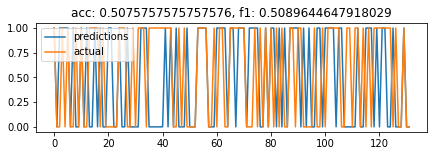

pca variance: 0.9727678635823727
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


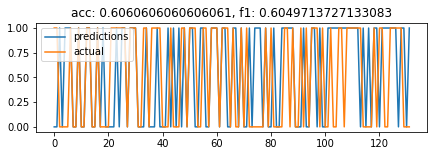

pca variance: 0.9727703083836545
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


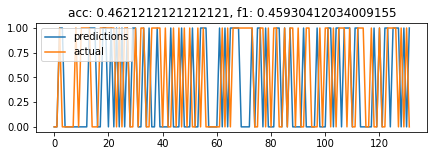

pca variance: 0.9731882823073867
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


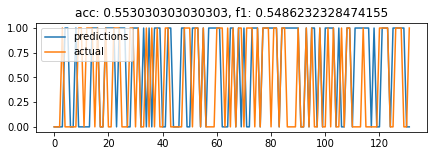

pca variance: 0.9730024007728852
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


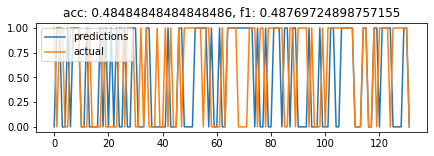

pca variance: 0.9729707866439101
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


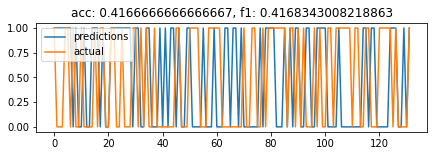

pca variance: 0.9731063600640985
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


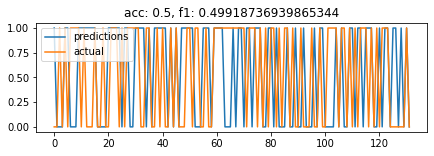

pca variance: 0.9726301029140393
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


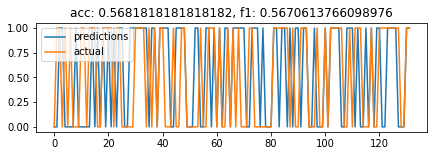

pca variance: 0.9727869355283092
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


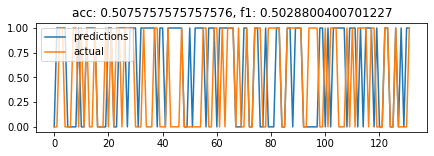

pca variance: 0.9722819044971525
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


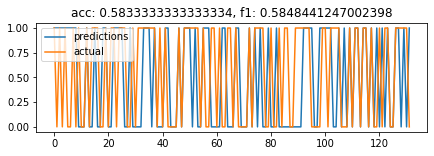

pca variance: 0.9723911480466824
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


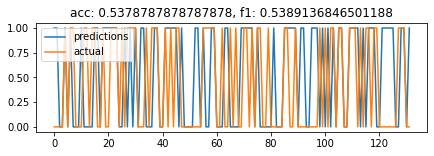

pca variance: 0.9722803316194625
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


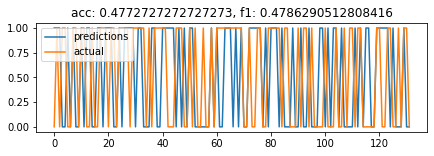

pca variance: 0.9723956988250695
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


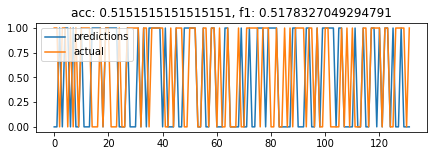

pca variance: 0.97264392173102
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


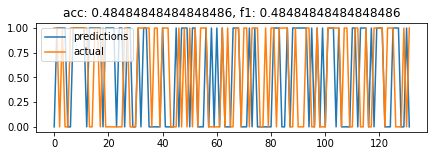

pca variance: 0.9723492381063462
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


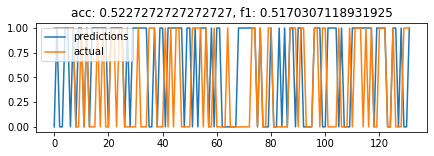

pca variance: 0.9726338851318146
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


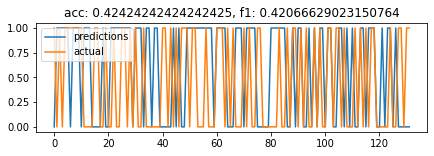

pca variance: 0.9722499791945204
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


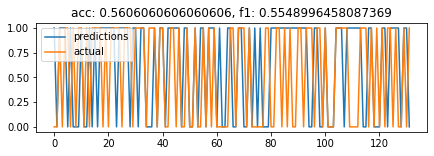

pca variance: 0.9722206283031577
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


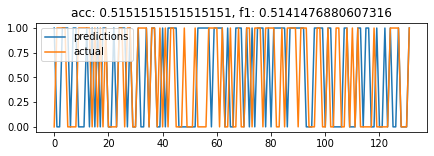

pca variance: 0.9719914845381302
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


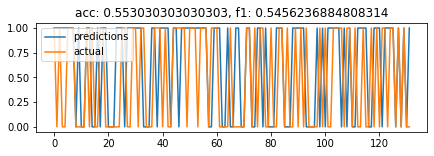

pca variance: 0.9719418636247443
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


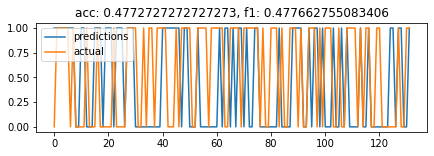

pca variance: 0.9718280932477604
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


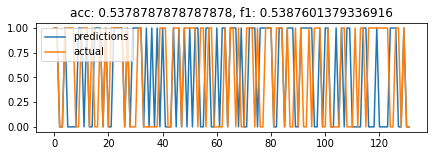

pca variance: 0.9718382403518535
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


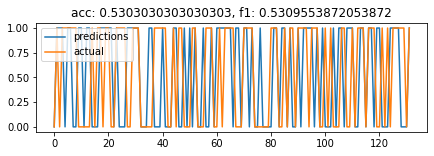

pca variance: 0.9720136931977764
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


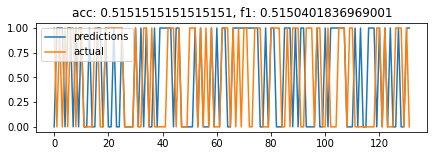

pca variance: 0.9716895536689723
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


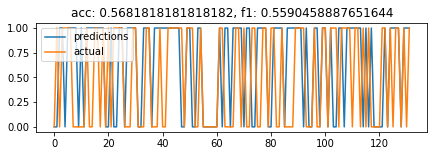

pca variance: 0.9722302519954922
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


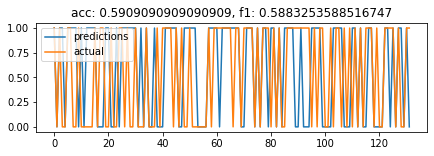

pca variance: 0.972028504833026
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


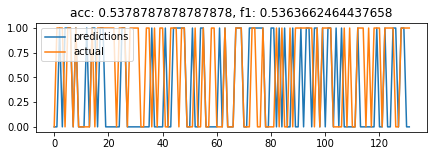

pca variance: 0.9717295641664851
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


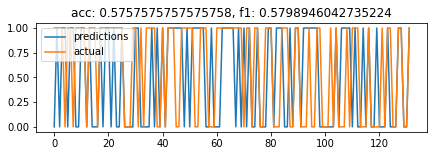

pca variance: 0.9719858824429368
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


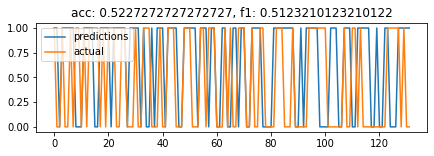

pca variance: 0.9722505661288299
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


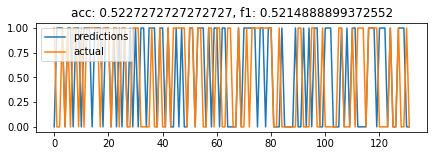

pca variance: 0.9723561336719057
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


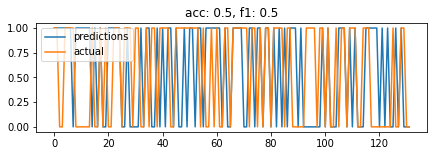

pca variance: 0.9723001683318809
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


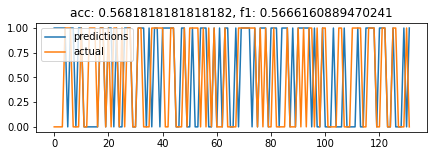

pca variance: 0.9721960998093547
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


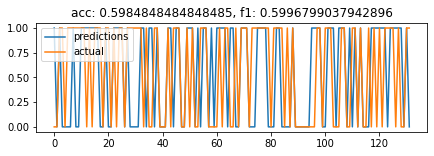

pca variance: 0.972305147411841
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


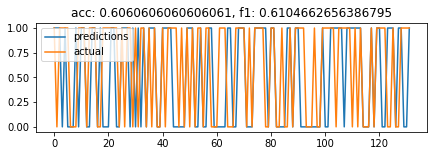

pca variance: 0.9717726888927624
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


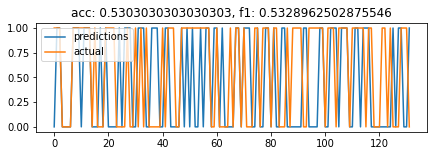

pca variance: 0.9715264722551001
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


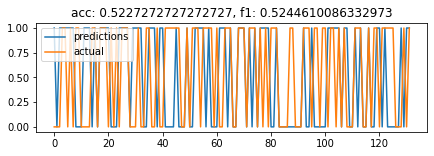

pca variance: 0.9711708873793272
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


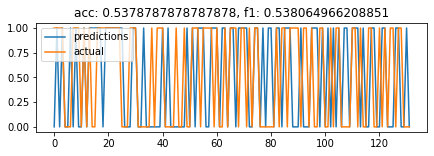

pca variance: 0.9715238050622371
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


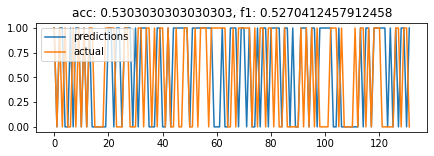

pca variance: 0.971695265924005
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


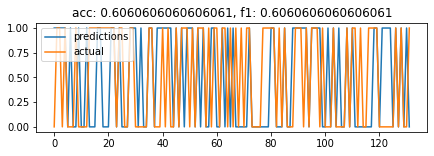

pca variance: 0.9713187152526349
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


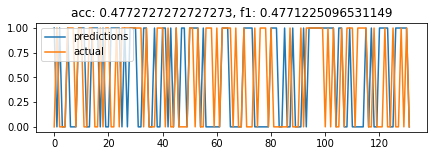

pca variance: 0.9711873321969612
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


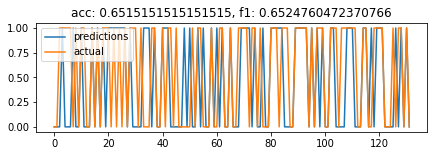

pca variance: 0.9712262618327792
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


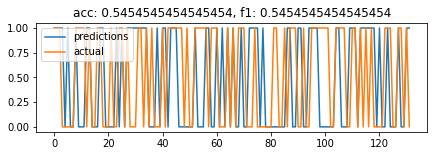

pca variance: 0.9711253528931743
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


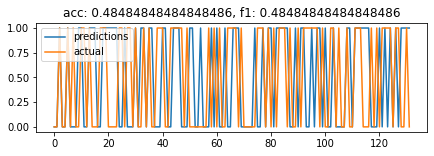

loading or generating classifier data for: NDAQ, M1
running up to start of file: 2021-06-01 -> 2021-08-02
pca variance: 0.9722697992351711
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


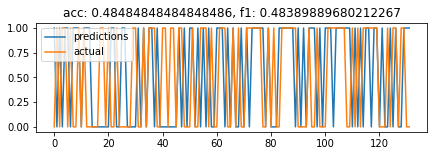

pca variance: 0.9728625273179324
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


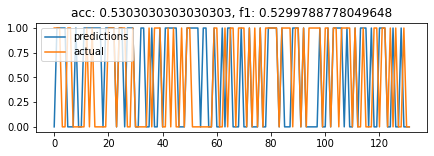

pca variance: 0.9727678635823727
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


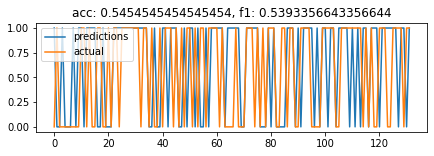

pca variance: 0.9727703083836545
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


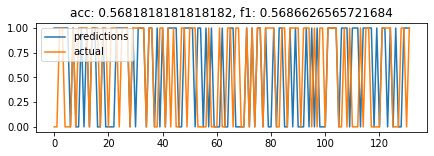

pca variance: 0.9731882823073867
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


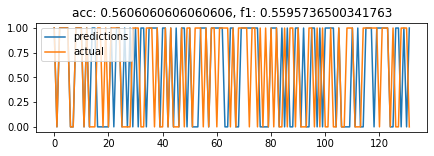

pca variance: 0.9730024007728852
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


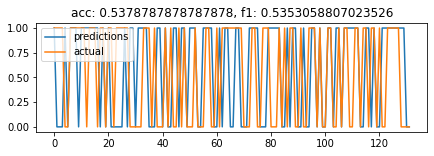

pca variance: 0.9729707866439101
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


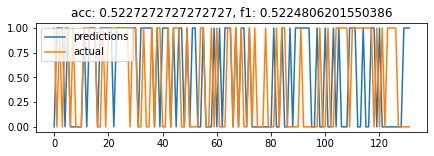

pca variance: 0.9731063600640985
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


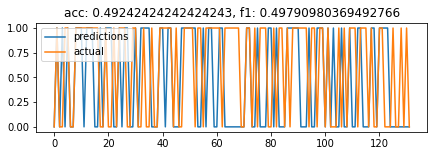

pca variance: 0.9726301029140393
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


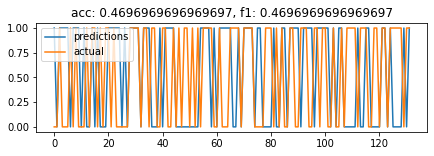

pca variance: 0.9727869355283092
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


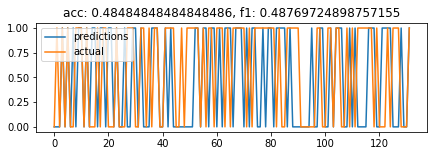

pca variance: 0.9722819044971525
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


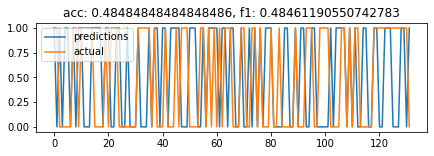

pca variance: 0.9723911480466824
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


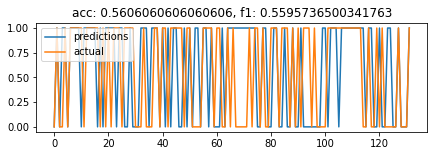

pca variance: 0.9722803316194625
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


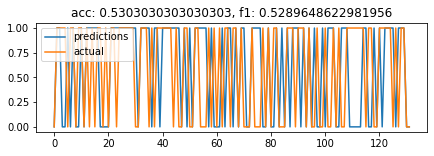

pca variance: 0.9723956988250695
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


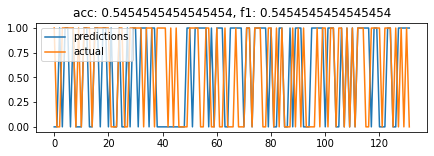

pca variance: 0.97264392173102
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


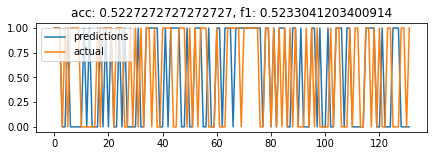

pca variance: 0.9723492381063462
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


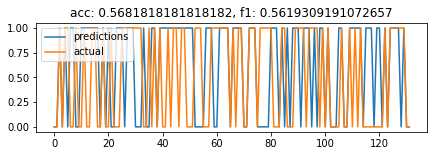

pca variance: 0.9726338851318146
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


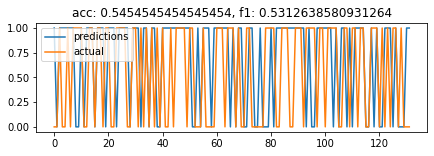

pca variance: 0.9722499791945204
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


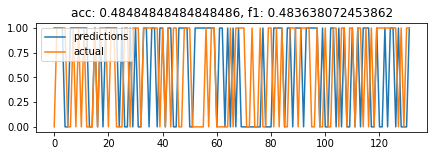

pca variance: 0.9722206283031577
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


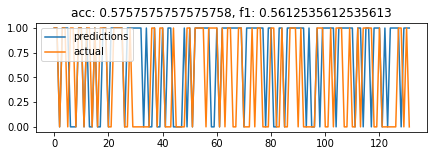

pca variance: 0.9719914845381302
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


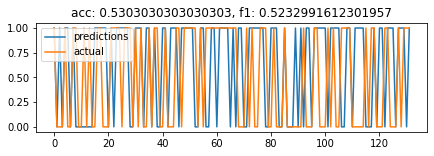

pca variance: 0.9719418636247443
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


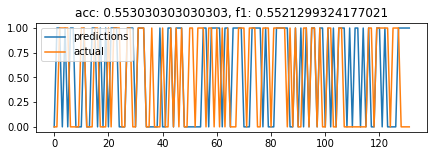

pca variance: 0.9718280932477604
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


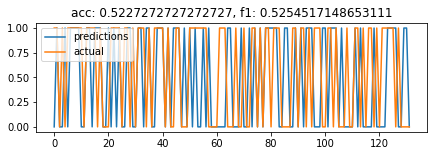

pca variance: 0.9718382403518535
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


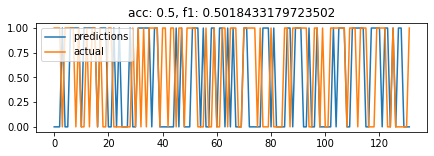

pca variance: 0.9720136931977764
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


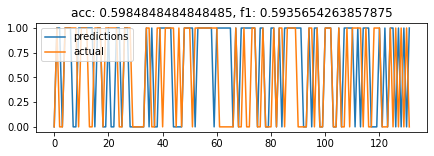

pca variance: 0.9716895536689723
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


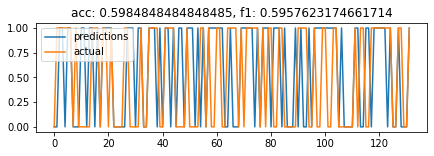

pca variance: 0.9722302519954922
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


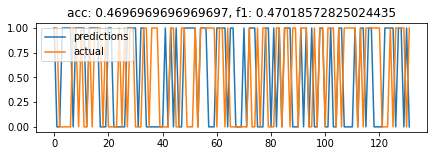

pca variance: 0.972028504833026
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


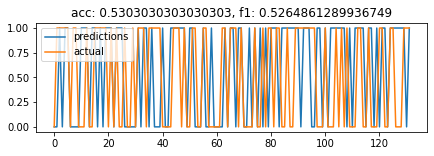

pca variance: 0.9717295641664851
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


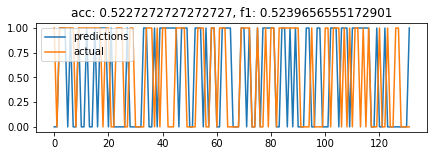

pca variance: 0.9719858824429368
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


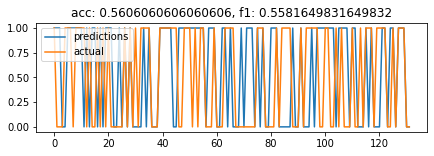

pca variance: 0.9722505661288299
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


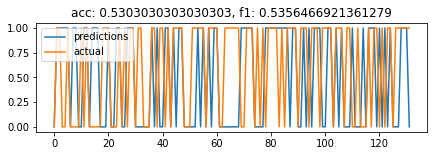

pca variance: 0.9723561336719057
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


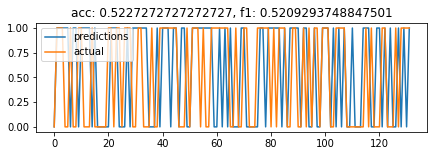

pca variance: 0.9723001683318809
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


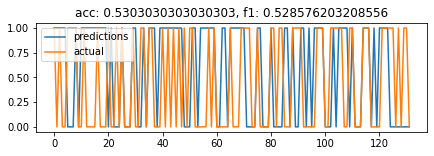

pca variance: 0.9721960998093547
Params: {'activation': 'relu', 'hidden_layer_sizes': (56, 28), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


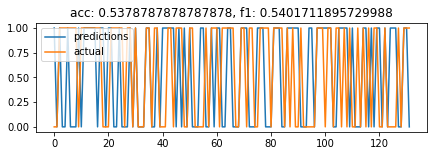

pca variance: 0.972305147411841
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


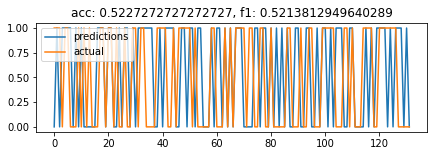

pca variance: 0.9717726888927624
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


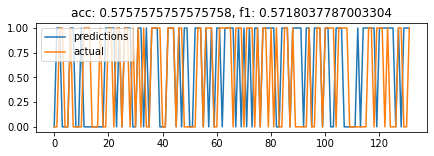

pca variance: 0.9715264722551001
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


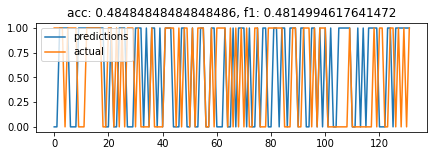

pca variance: 0.9711708873793272
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


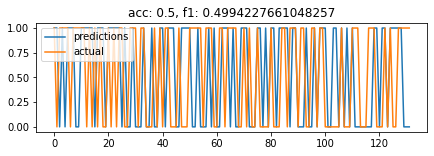

pca variance: 0.9715238050622371
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


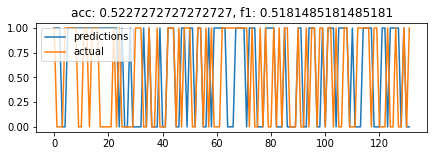

pca variance: 0.971695265924005
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


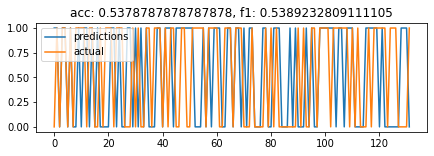

pca variance: 0.9713187152526349
Params: {'activation': 'relu', 'hidden_layer_sizes': (28, 14), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


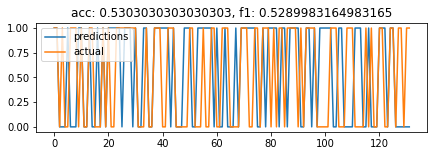

pca variance: 0.9711873321969612
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


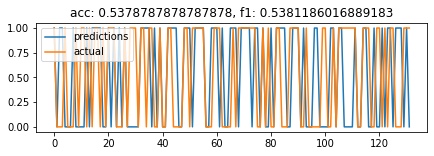

pca variance: 0.9712262618327792
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


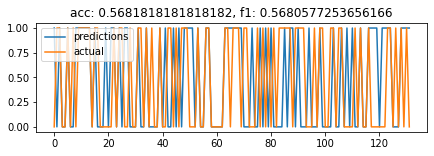

pca variance: 0.9711253528931743
Params: {'activation': 'relu', 'hidden_layer_sizes': (64, 32, 16), 'learning_rate_init': 0.01, 'max_iter': 100, 'solver': 'adam'}


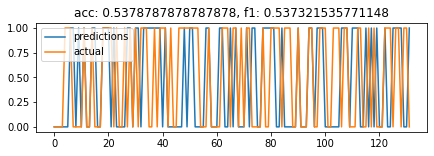

In [62]:
dataset_classifier_results = {}
for dataset in datasets: 
    classifier_results = {}
    base_prices = price_data[datasets[dataset].label]
    df = dataset_results[dataset]
    for classifier_key in classifiers:
        if classifier_load_mode == 'file':
            print('loading classifier data for: ' + dataset + ', ' + classifier_key)
            classifier_results[classifier_key] = pd.read_csv(OUTPUT_PATH + 'classifiers\\' + dataset + '_' + classifier_key + '.csv')
        elif classifier_load_mode == 'generate':
            print('generating classifier data for: ' + dataset + ', ' + classifier_key)
            classifier = classifiers[classifier_key] 
            start_ind, end_ind = df.index.get_loc(start_date), df.index.get_loc(end_date) + 1
            classifier_results[classifier_key] = GenerateModelResults(df, base_prices, classifier, pca_comps, 1, no_samples, test_size, range(start_ind, end_ind)) 
        elif classifier_load_mode == 'file_or_generate':
            print('loading or generating classifier data for: ' + dataset + ', ' + classifier_key)
            classifier, classifier_data = classifiers[classifier_key], []
            if os.path.exists(OUTPUT_PATH + 'classifiers\\' + dataset + '_' + classifier_key + '.csv'):
                classifier_data.append(pd.read_csv(OUTPUT_PATH + 'classifiers\\' + dataset + '_' + classifier_key + '.csv'))
            for run_range in GetClassifierDatasetRunRange(start_date, end_date, df, classifier_data):
                classifier_data.append(GenerateModelResults(df, base_prices, classifier, pca_comps, 1, no_samples, test_size, run_range))
            classifier_results[classifier_key] = pd.concat(classifier_data)
            classifier_results[classifier_key].sort_values(['date'], inplace=True)
        
        if classifier_save_rslt and classifier_load_mode != 'file':
            classifier_results[classifier_key].to_csv(OUTPUT_PATH + 'classifiers\\' + dataset + '_' + classifier_key + '.csv', index=False)    
                
    dataset_classifier_results[dataset] = classifier_results

In [57]:
dataset_classifier_results['500.PAR']['M1']

date                                             params   test_F1  \
0   2021-08-02  {'activation': 'relu', 'hidden_layer_sizes': (...  0.546302   
1   2021-08-03  {'activation': 'relu', 'hidden_layer_sizes': (...  0.528571   
2   2021-08-04  {'activation': 'relu', 'hidden_layer_sizes': (...  0.507547   
3   2021-08-05  {'activation': 'relu', 'hidden_layer_sizes': (...  0.540316   
4   2021-08-06  {'activation': 'relu', 'hidden_layer_sizes': (...  0.562308   
5   2021-08-09  {'activation': 'relu', 'hidden_layer_sizes': (...  0.565763   
6   2021-08-10  {'activation': 'relu', 'hidden_layer_sizes': (...  0.539554   
7   2021-08-11  {'activation': 'relu', 'hidden_layer_sizes': (...  0.511069   
8   2021-08-12  {'activation': 'relu', 'hidden_layer_sizes': (...  0.485443   
9   2021-08-13  {'activation': 'relu', 'hidden_layer_sizes': (...  0.520929   
10  2021-08-16  {'activation': 'relu', 'hidden_layer_sizes': (...  0.547961   
11  2021-08-17  {'activation': 'relu', 'hidden_layer_sizes': (...  0.506809   
12  2021-08-18  {'activation': 'relu', 'hidden_layer_sizes': (...  0.492807   
13  2021-08-19  {'activation': 'relu', 'hidden_layer_sizes': (...  0.436661   
14  2021-08-20  {'activation': 'relu', 'hidden_layer_sizes': (...  0.526486   
15  2021-08-23  {'activation': 'relu', 'hidden_layer_sizes': (...  0.500000   
16  2021-08-24  {'activation': 'relu', 'hidden_layer_sizes': (...  0.544823   
17  2021-08-25  {'activation': 'relu', 'hidden_layer_sizes': (...  0.498825   
18  2021-08-26  {'activation': 'relu', 'hidden_layer_sizes': (...  0.530519   
19  2021-08-27  {'activation': 'relu', 'hidden_layer_sizes': (...  0.511999   
20  2021-08-30  {'activation': 'relu', 'hidden_layer_sizes': (...  0.483424   
21  2021-08-31  {'activation': 'relu', 'hidden_layer_sizes': (...  0.472119   
22  2021-09-01  {'activation': 'relu', 'hidden_layer_sizes': (...  0.505787   
23  2021-09-02  {'activation': 'relu', 'hidden_layer_sizes': (...  0.499423   
24  2021-09-03  {'activation': 'relu', 'hidden_layer_sizes': (...  0.514032   
25  2021-09-07  {'activation': 'relu', 'hidden_layer_sizes': (...  0.512693   
26  2021-09-08  {'activation': 'relu', 'hidden_layer_sizes': (...  0.513344   
27  2021-09-09  {'activation': 'relu', 'hidden_layer_sizes': (...  0.622524   
28  2021-09-10  {'activation': 'relu', 'hidden_layer_sizes': (...  0.515580   
29  2021-09-13  {'activation': 'relu', 'hidden_layer_sizes': (...  0.530842   
30  2021-09-14  {'activation': 'relu', 'hidden_layer_sizes': (...  0.515152   
0   2021-09-15  {'activation': 'relu', 'hidden_layer_sizes': (...  0.535822   
1   2021-09-16  {'activation': 'relu', 'hidden_layer_sizes': (...  0.515625   
2   2021-09-17  {'activation': 'relu', 'hidden_layer_sizes': (...  0.545872   
3   2021-09-20  {'activation': 'relu', 'hidden_layer_sizes': (...  0.528139   
4   2021-09-21  {'activation': 'relu', 'hidden_layer_sizes': (...  0.566917   
5   2021-09-22  {'activation': 'relu', 'hidden_layer_sizes': (...  0.467248   
6   2021-09-23  {'activation': 'relu', 'hidden_layer_sizes': (...  0.520612   
7   2021-09-24  {'activation': 'relu', 'hidden_layer_sizes': (...  0.507830   
8   2021-09-27  {'activation': 'relu', 'hidden_layer_sizes': (...  0.568256   
9   2021-09-28  {'activation': 'relu', 'hidden_layer_sizes': (...  0.522311   
10  2021-09-29  {'activation': 'relu', 'hidden_layer_sizes': (...  0.537639   
11  2021-09-30  {'activation': 'relu', 'hidden_layer_sizes': (...  0.486273   

    prediction  
0            1  
1           -1  
2            1  
3            1  
4            1  
5           -1  
6           -1  
7            1  
8            1  
9            1  
10          -1  
11           1  
12          -1  
13           1  
14           1  
15           1  
16           1  
17           1  
18           1  
19           1  
20           1  
21          -1  
22          -1  
23           1  
24           1  
25          -1  
26          -1  
27          -1  
28           1  
29          -1  
30    

In [13]:
dataset_classifier_results['NDAQ']['M1']

date                                             params   test_F1  \
0   2021-09-15  {'activation': 'relu', 'hidden_layer_sizes': (...  0.516934   
1   2021-09-16  {'activation': 'relu', 'hidden_layer_sizes': (...  0.544198   
2   2021-09-17  {'activation': 'relu', 'hidden_layer_sizes': (...  0.545246   
3   2021-09-20  {'activation': 'relu', 'hidden_layer_sizes': (...  0.477243   
4   2021-09-21  {'activation': 'relu', 'hidden_layer_sizes': (...  0.506868   
5   2021-09-22  {'activation': 'relu', 'hidden_layer_sizes': (...  0.569050   
6   2021-09-23  {'activation': 'relu', 'hidden_layer_sizes': (...  0.530195   
7   2021-09-24  {'activation': 'relu', 'hidden_layer_sizes': (...  0.519507   
8   2021-09-27  {'activation': 'relu', 'hidden_layer_sizes': (...  0.516595   
9   2021-09-28  {'activation': 'relu', 'hidden_layer_sizes': (...  0.447446   
10  2021-09-29  {'activation': 'relu', 'hidden_layer_sizes': (...  0.423184   
11  2021-09-30  {'activation': 'relu', 'hidden_layer_sizes': (...  0.478083   

    prediction  
0            1  
1           -1  
2           -1  
3           -1  
4           -1  
5           -1  
6           -1  
7           -1  
8            1  
9            1  
10           1  
11           1

<h1>Trader</h1>
<p>Every trader definition is generated for every classifier. They convert classifier signals to a normalised daily return using sell-off rules</p>

In [14]:
norm_price = True

In [15]:
dataset_classifier_predictor_results = {}
for dataset in datasets:
    classifier_predictor_results = {}
    base_prices = price_data[datasets[dataset].label]
    df  = dataset_results[dataset]
    for classifier_key in classifiers:
        predictor_results = {}
        classifier_results = dataset_classifier_results[dataset][classifier_key]
        for predictor_key in predictors:
            if trader_load_mode == 'file':
                print('loading trader data for: ' + dataset + ', ' + classifier_key + ', ' + predictor_key)
                predictor_results[predictor_key] = pd.read_csv(OUTPUT_PATH + 'traders\\' + dataset + '_' + classifier_key + '_' + predictor_key + '.csv')
            elif trader_load_mode == 'generate':
                print('generating trader data: ' + dataset + ', ' + classifier_key + ', ' + predictor_key)
                start_ind, end_ind = df.index.get_loc(start_date), df.index.get_loc(end_date)+1
                predictor_results[predictor_key] = GeneratePredictorResults(df, base_prices, predictors[predictor_key], classifier_results, range(start_ind, end_ind), norm_price)
            if trader_save_rslt:
                predictor_results[predictor_key].to_csv(OUTPUT_PATH + 'traders\\' + dataset + '_' + classifier_key + '_' + predictor_key + '.csv', index=False)
        classifier_predictor_results[classifier_key] = predictor_results
    dataset_classifier_predictor_results[dataset] = classifier_predictor_results

loading trader data for: 500.PAR, M1, P1
loading trader data for: 500.PAR, M1, P2
loading trader data for: 500.PAR, M1, P3
loading trader data for: 500.PAR, M1, P4
loading trader data for: NDAQ, M1, P1
loading trader data for: NDAQ, M1, P2
loading trader data for: NDAQ, M1, P3
loading trader data for: NDAQ, M1, P4


In [16]:
dataset_classifier_predictor_results['500.PAR']['M1']['P1']

date   bought_at  prediction     sold_at  perc_pal
0   2021-09-15  188.100900           1  188.139668  0.000206
1   2021-09-16  233.283988           1  232.767613 -0.002214
2   2021-09-17  237.532200          -1  235.150054  0.010029
3   2021-09-20  181.256178           1  179.706564 -0.008549
4   2021-09-21  187.082689           1  186.850329 -0.001242
5   2021-09-22  187.081720           1  187.911897  0.004438
6   2021-09-23  177.190230           1  178.516219  0.007483
7   2021-09-24  175.527845          -1  176.083829 -0.003167
8   2021-09-27  164.967801          -1  164.043256  0.005604
9   2021-09-28  160.462322          -1  157.901364  0.015960
10  2021-09-29  146.814832           1  147.702730  0.006048
11  2021-09-30  139.909990           1  138.742009 -0.008348

In [17]:
dataset_classifier_predictor_results['500.PAR']['M1']['P2']

date   bought_at  prediction     sold_at  perc_pal
0   2021-09-15  188.100900           1  188.139668  0.000206
1   2021-09-16  233.283988           1  232.767613 -0.002214
2   2021-09-17  237.532200          -1  235.750709  0.007500
3   2021-09-20  181.256178           1  179.706564 -0.008549
4   2021-09-21  187.082689           1  186.850329 -0.001242
5   2021-09-22  187.081720           1  187.911897  0.004438
6   2021-09-23  177.190230           1  178.516219  0.007483
7   2021-09-24  175.527845          -1  176.083829 -0.003167
8   2021-09-27  164.967801          -1  164.043256  0.005604
9   2021-09-28  160.462322          -1  159.258854  0.007500
10  2021-09-29  146.814832           1  147.915944  0.007500
11  2021-09-30  139.909990           1  138.742009 -0.008348

In [18]:
dataset_classifier_predictor_results['500.PAR']['M1']['P3']

date   bought_at  prediction     sold_at  perc_pal
0   2021-09-15  188.100900           0  188.139668  0.000000
1   2021-09-16  233.283988           0  232.767613  0.000000
2   2021-09-17  237.532200          -1  235.150054  0.010029
3   2021-09-20  181.256178           0  179.706564  0.000000
4   2021-09-21  187.082689           0  186.850329  0.000000
5   2021-09-22  187.081720           0  187.911897  0.000000
6   2021-09-23  177.190230           0  178.516219  0.000000
7   2021-09-24  175.527845          -1  176.083829 -0.003167
8   2021-09-27  164.967801          -1  164.043256  0.005604
9   2021-09-28  160.462322          -1  157.901364  0.015960
10  2021-09-29  146.814832           0  147.702730  0.000000
11  2021-09-30  139.909990           0  138.742009  0.000000

In [19]:
dataset_classifier_predictor_results['500.PAR']['M1']['P4']

date   bought_at  prediction     sold_at  perc_pal
0   2021-09-15  188.100900           0  188.139668  0.000000
1   2021-09-16  233.283988           0  232.767613  0.000000
2   2021-09-17  237.532200          -1  235.750709  0.007500
3   2021-09-20  181.256178           0  179.706564  0.000000
4   2021-09-21  187.082689           0  186.850329  0.000000
5   2021-09-22  187.081720           0  187.911897  0.000000
6   2021-09-23  177.190230           0  178.516219  0.000000
7   2021-09-24  175.527845          -1  176.083829 -0.003167
8   2021-09-27  164.967801          -1  164.043256  0.005604
9   2021-09-28  160.462322          -1  159.258854  0.007500
10  2021-09-29  146.814832           0  147.702730  0.000000
11  2021-09-30  139.909990           0  138.742009  0.000000

<h1>Allocators</h1>
<p>Allocators take all the traders and score them then allocate to them based on previous days score</p>

In [30]:
allocator_results, allocator_returns = {}, {}
for pk in allocators:
    if allocator_load_mode == 'file':
        print('loading allocator data for: ' + pk)
        allocator_results[pk] = pd.read_csv(OUTPUT_PATH + 'allocators\\' + pk + '.csv')
    elif allocator_load_mode == 'generate':
        print('generating allocator data for: ' + pk)
        allocator_results[pk] = allocators[pk].GeneratePortfolioResults(dataset_classifier_predictor_results, predictors)
        
    if allocator_save_rslt:
        allocator_results[pk].to_csv(OUTPUT_PATH + 'allocators\\'  + pk + '.csv', index=False)
    allocator_returns[pk] = GeneratePortfolioReturns(allocator_results[pk])

generating allocator data for: A1
generating allocator data for: A2


In [21]:
allocator_results['A1'][(allocator_results['A1']['date']=='2021-09-24')]

date   symbol classifier predictor    exit_method   bought_at  \
7  2021-09-24  500.PAR         M1        P1       at_close  175.527845   
7  2021-09-24  500.PAR         M1        P2  capture_gains  175.527845   
7  2021-09-24  500.PAR         M1        P3       at_close  175.527845   
7  2021-09-24  500.PAR         M1        P4  capture_gains  175.527845   
7  2021-09-24     NDAQ         M1        P1       at_close  270.577928   
7  2021-09-24     NDAQ         M1        P2  capture_gains  270.577928   
7  2021-09-24     NDAQ         M1        P3       at_close  270.577928   
7  2021-09-24     NDAQ         M1        P4  capture_gains  270.577928   

   prediction  5D_mean_pal_S1      lerp    weight    amount     sold_at  \
7          -1        0.002432  1.000000  0.179004 -0.179004  176.083829   
7          -1        0.001926  0.825849  0.147830 -0.147830  176.083829   
7          -1        0.002006  0.853336  0.152751 -0.152751  176.083829   
7          -1        0.001500  0.679185  0.121577 -0.121577  176.083829   
7          -1        0.000254  0.250000  0.044751 -0.044751  273.173899   
7          -1        0.002037  0.864044  0.154668 -0.154668  273.173899   
7          -1        0.000254  0.250000  0.044751 -0.044751  273.173899   
7          -1        0.002037  0.864044  0.154668 -0.154668  273.173899   

   perc_pal  weighted_pal  
7 -0.003167     -0.000567  
7 -0.003167     -0.000468  
7 -0.003167     -0.000484  
7 -0.003167     -0.000385  
7 -0.009594     -0.000429  
7 -0.009594     -0.001484  
7 -0.009594     -0.000429  
7 -0.009594     -0.001484

In [22]:
allocator_results['A2'][(allocator_results['A2']['date']=='2021-09-24')]

date   symbol classifier predictor    exit_method   bought_at  \
7  2021-09-24  500.PAR         M1        P3       at_close  175.527845   
7  2021-09-24  500.PAR         M1        P4  capture_gains  175.527845   
7  2021-09-24     NDAQ         M1        P3       at_close  270.577928   
7  2021-09-24     NDAQ         M1        P4  capture_gains  270.577928   

   prediction  5D_mean_pal_S1      lerp    weight    amount     sold_at  \
7          -1        0.002006  0.986921  0.327758 -0.327758  176.083829   
7          -1        0.001500  0.774211  0.257116 -0.257116  176.083829   
7          -1        0.000254  0.250000  0.083025 -0.083025  273.173899   
7          -1        0.002037  1.000000  0.332101 -0.332101  273.173899   

   perc_pal  weighted_pal  
7 -0.003167     -0.001038  
7 -0.003167     -0.000814  
7 -0.009594     -0.000797  
7 -0.009594     -0.003186

In [23]:
allocator_returns['A1']

date  weight  weighted_pal   3D_mean  3D_cumprod   5D_mean  \
0   2021-09-15     0.0      0.000000       NaN         NaN       NaN   
1   2021-09-16     0.0      0.000000       NaN         NaN       NaN   
2   2021-09-17     0.0      0.000000  0.000000    0.000000       NaN   
3   2021-09-20     0.0      0.000000  0.000000    0.000000       NaN   
4   2021-09-21     0.0      0.000000  0.000000    0.000000  0.000000   
5   2021-09-22     1.0      0.001599  0.000533    0.001599  0.000320   
6   2021-09-23     1.0      0.000442  0.000680    0.002042  0.000408   
7   2021-09-24     1.0     -0.005731 -0.001230   -0.003700 -0.000738   
8   2021-09-27     1.0      0.002932 -0.000786   -0.002375 -0.000151   
9   2021-09-28     1.0      0.005435  0.000879    0.002604  0.000936   
10  2021-09-29     1.0      0.003505  0.003957    0.011918  0.001317   
11  2021-09-30     1.0     -0.003589  0.001784    0.005338  0.000510   

    5D_cumprod  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4     0.000000  
5     0.001599  
6     0.002042  
7    -0.003700  
8    -0.000779  
9     0.004652  
10    0.006563  
11    0.002507

In [25]:
allocator_returns['A2']

date  weight  weighted_pal   3D_mean  3D_cumprod   5D_mean  \
0   2021-09-15     0.0      0.000000       NaN         NaN       NaN   
1   2021-09-16     0.0      0.000000       NaN         NaN       NaN   
2   2021-09-17     0.0      0.000000  0.000000    0.000000       NaN   
3   2021-09-20     0.0      0.000000  0.000000    0.000000       NaN   
4   2021-09-21     0.0      0.000000  0.000000    0.000000  0.000000   
5   2021-09-22     1.0     -0.000490 -0.000163   -0.000490 -0.000098   
6   2021-09-23     1.0     -0.000429 -0.000306   -0.000919 -0.000184   
7   2021-09-24     1.0     -0.005835 -0.002251   -0.006749 -0.001351   
8   2021-09-27     1.0      0.003656 -0.000869   -0.002629 -0.000620   
9   2021-09-28     1.0      0.007523  0.001781    0.005306  0.000885   
10  2021-09-29     1.0      0.000000  0.003726    0.011207  0.000983   
11  2021-09-30     1.0      0.000000  0.002508    0.007523  0.001069   

    5D_cumprod  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4     0.000000  
5    -0.000490  
6    -0.000919  
7    -0.006749  
8    -0.003117  
9     0.004382  
10    0.004874  
11    0.005306

In [24]:
GenerateInstructions('2021-09-24', allocator_results['A1'])

date   symbol    exit_method   bought_at    amount
0  2021-09-24  500.PAR       at_close  175.527845 -0.331755
1  2021-09-24  500.PAR  capture_gains  175.527845 -0.269407
2  2021-09-24     NDAQ       at_close  270.577928 -0.089502
3  2021-09-24     NDAQ  capture_gains  270.577928 -0.309335

In [28]:
GenerateInstructions('2021-09-24', allocator_results['A2'])

date   symbol    exit_method   bought_at    amount
0  2021-09-24  500.PAR       at_close  175.527845 -0.327758
1  2021-09-24  500.PAR  capture_gains  175.527845 -0.257116
2  2021-09-24     NDAQ       at_close  270.577928 -0.083025
3  2021-09-24     NDAQ  capture_gains  270.577928 -0.332101